# Explanatory Data Analysis and Preprocessing

### Data Structure

In this case the data are structured as follows in order to recreate the project.
```
.
├── Healthcare 
│   └── data.csv
├── Heart_Rate_Prediction
│   ├── Test Data
│   │   ├── frequency_domain_features_test.csv
│   │   ├── heart_rate_non_linear_features_test.csv
│   │   └── time_domain_features_test.csv
│   └── Train Data
│       ├── frequency_domain_features_train.csv
│       ├── heart_rate_non_linear_features_train.csv
│       └── time_domain_features_train.csv
├── SWELL
│   ├── test.csv
│   └── train.csv
└── Stress_predict
    ├── Questionnaires_scores.xlsx
    ├── Time_logs.xlsx
    └── data.csv
```


In [1]:
# Import Libraries
import os, sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from helper import compute_hrv_from_heart_rate


# Import Data Paths
data_path = os.getcwd() + "/data" 

[{'rmssd': 12.11, 'sdnn': 18.55, 'window': '0-14', 'start_timestamp': '2023-10-01T00:00:00Z'}]


### Healthcare dataset for Nurse Stress Prediction with Wearable devices

- Data Collection Context:
    - Period: Data gathered over one week from 15 female nurses aged 30 to 55 years

- Data Captured:
    - Physiological Variables Monitored: Heart Rate of the nurse subjects.
    - Survey Responses: Periodic smartphone-administered surveys capturing contributing factors to detected stress events.
    - Measurement Technologies: Utilized Empatica E4 for data collection, specifically focusing on Blood Volume Pulse (BVP) readings.

- Merge CSV File Information:
    - This dataset comprises approximately 11.5 million entries across nine columns:
    - X, Y, Z: Orientation data (256 unique entries each).
    - EDA, HR, TEMP: Physiological measurements (EDA: 274,452 unique, HR: 6,268 unique, TEMP: 599 unique).
    - id: 18 categorical identifiers.
    - datetime: Extensive date and time entries (10.6 million unique).
    - label: Categorical states or classes (three unique entries).

In [2]:
# Data path 
health_care_path = os.path.join(data_path, "Healthcare/data.csv")
nurses_pd = pd.read_csv(health_care_path)
print("The initial data contains {} rows and {} columns.".format(nurses_pd.shape[0], nurses_pd.shape[1]))

# Data Preprocessing (drop unnecessary columns and convert label to int)
data_pd = nurses_pd.drop(columns=["X", "Y", "Z", "EDA", "TEMP", "id"])
print("The data we are interested in contains {} rows and {} columns.".format(data_pd.shape[0], data_pd.shape[1]))

# Calculate time difference between consecutive samples (in seconds), drop the first NaN and calculate average time
# Ensure the datetime column is of datetime type
data_pd["datetime"] = pd.to_datetime(data_pd["datetime"])
data_pd = data_pd.sort_values(by="datetime")
data_pd["time_diff"] = data_pd["datetime"].diff().dt.total_seconds()
data_pd = data_pd.dropna(subset=["time_diff"])
average_time_diff = data_pd["time_diff"].mean()
data_pd.drop(columns=["time_diff"], inplace=True)

# Calculate frequency (Hz)
sampling_frequency_hz = 1 / average_time_diff
print(f"Average Time Between Samples: {average_time_diff:.6f} seconds")
print(f"Sampling Frequency: {sampling_frequency_hz:.2f} Hz")

/var/folders/k5/22sywl_15k17yky84cqwzc_80000gn/T/ipykernel_31023/3214513553.py:3: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  nurses_pd = pd.read_csv(health_care_path)


The initial data contains 11509051 rows and 9 columns.
The data we are interested in contains 11509051 rows and 3 columns.
Average Time Between Samples: 1.819698 seconds
Sampling Frequency: 0.55 Hz


In [3]:
# Resample to 1-second intervals using average
data_pd.set_index('datetime', inplace=True)
resampled_df = data_pd.resample('1S').mean(numeric_only=True)
resampled_df = resampled_df.dropna(subset=['HR'])
resampled_df["label"] = resampled_df["label"].astype(int)
resampled_df.to_csv(os.path.join(data_path, "Healthcare/resampled_data.csv"), index=True)
print("The data after resampling contains {} rows and {} columns.".format(resampled_df.shape[0], resampled_df.shape[1]))

The data after resampling contains 332307 rows and 2 columns.


In [4]:
# Load the downsampled data
data_pd = pd.read_csv(os.path.join(data_path, "Healthcare/resampled_data.csv"))
heart_rates = data_pd["HR"].value_counts()
labels = data_pd["label"].value_counts()

# Simple Statistical Analysis
mean_heart_rate = data_pd["HR"].mean()
median_heart_rate = data_pd["HR"].median()
std_heart_rate = data_pd["HR"].std()

print("The mean heart rate is {:.2f} bpm.".format(mean_heart_rate))
print("The median heart rate is {:.2f} bpm.".format(median_heart_rate))
print("The standard deviation of heart rate is {:.2f} bpm.".format(std_heart_rate))

The mean heart rate is 85.75 bpm.
The median heart rate is 84.07 bpm.
The standard deviation of heart rate is 14.06 bpm.


[Text(2, 0, '2'), Text(0, 0, '0'), Text(1, 0, '1')]

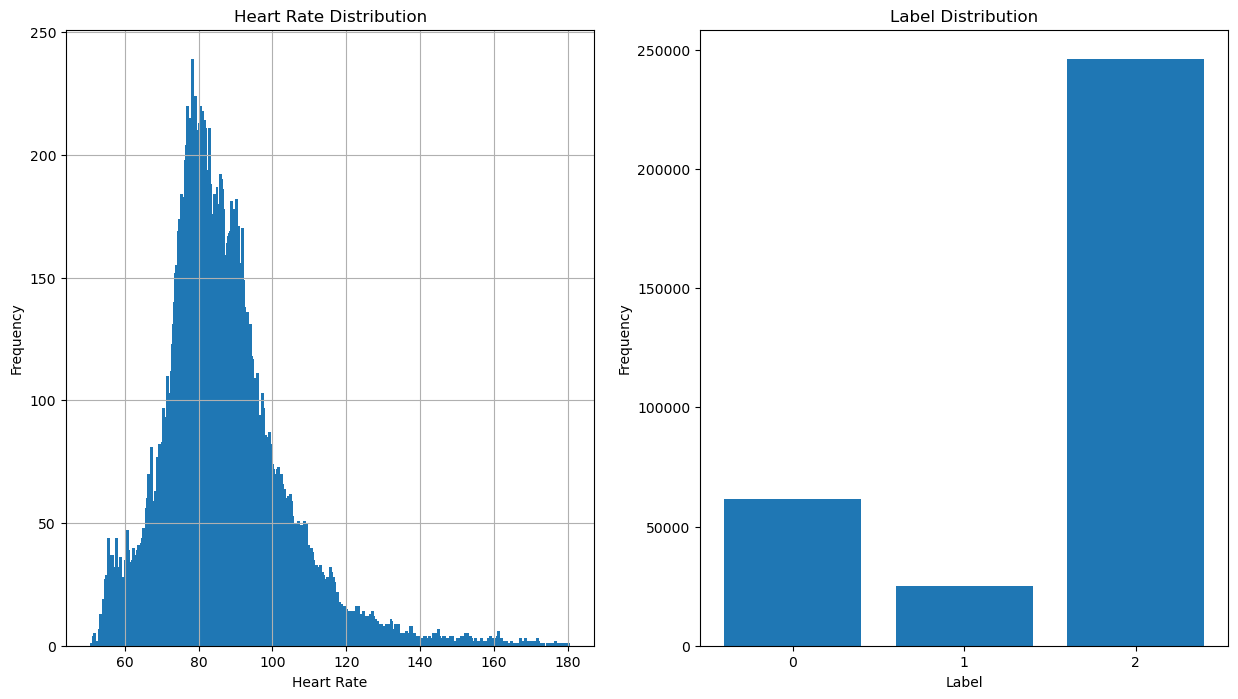

In [5]:
# Plot statistical data for the dataset
nrows = 1
ncols = 2

fig, axs = plt.subplots(nrows, ncols, figsize=(15, 8))

axs[0].bar(heart_rates.index, heart_rates.values)
axs[0].set_title("Heart Rate Distribution")
axs[0].set_xlabel("Heart Rate")
axs[0].set_ylabel("Frequency")
axs[0].grid()

axs[1].bar(labels.index, labels.values)
axs[1].set_title("Label Distribution")
axs[1].set_xlabel("Label")
axs[1].set_ylabel("Frequency")
axs[1].set_xticks(labels.index)
axs[1].set_xticklabels(labels.index.astype(int))

The data with HRV contains 332307 rows and 4 columns.


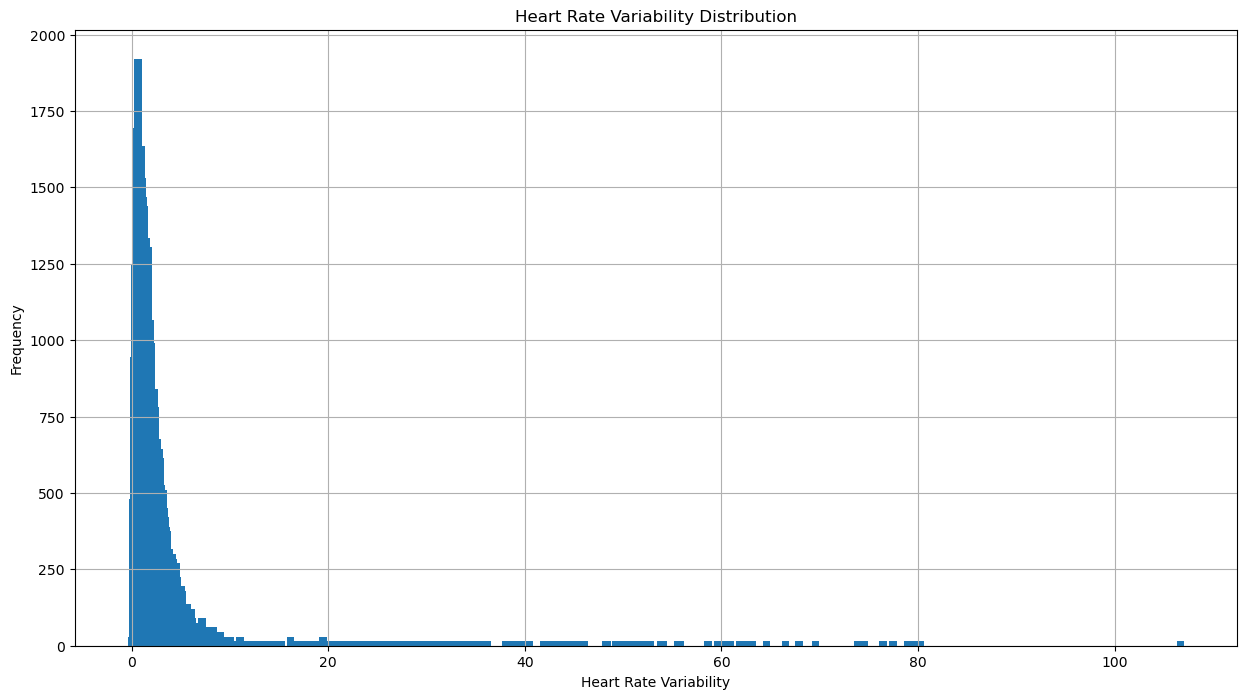

In [7]:
# Create a new column for HRV, calculate the difference between consecutive heart rates every 15 seconds
step = 15

# New HRV column to be filled
hrv_values = []

for i in range(0, len(data_pd), step):
    chunk = data_pd.iloc[i:i+step]
    if len(chunk) == step:
        hr_list = chunk["HR"].tolist()
        ts_list = chunk["datetime"].astype(str).tolist()
        hrv_result = compute_hrv_from_heart_rate(hr_list, windowed=False, timestamps=ts_list)
        hrv_rmssd = hrv_result["rmssd"]
        hrv_values.extend([hrv_rmssd] * 15)
    else:
        hrv_values.extend([np.nan] * len(chunk))

# Assign to new column
data_pd["HRV"] = hrv_values

# Export the data and delete downsampled data
data_pd = data_pd[["HR", "HRV", "datetime", "label"]]
data_pd.to_csv(os.path.join(data_path, "Healthcare/hrv.csv"), index=False)
print("The data with HRV contains {} rows and {} columns.".format(data_pd.shape[0], data_pd.shape[1]))

# Plot statistical data for the dataset
hrvs = data_pd["HRV"].value_counts()
nrows = 1
ncols = 1

fig, axs = plt.subplots(nrows, ncols, figsize=(15, 8))

axs.bar(hrvs.index, hrvs.values)
axs.set_title("Heart Rate Variability Distribution")
axs.set_xlabel("Heart Rate Variability")
axs.set_ylabel("Frequency")
axs.grid()

# Detete the resampled data
os.remove(os.path.join(data_path, "Healthcare/resampled_data.csv"))
